# Synthetic 1D inversion of Audio Magnetotelluric data


## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from scipy.sparse import diags

import cofi
import cofi_espresso
from cofi_espresso import Magnetotelluric1D

In [2]:
mt = Magnetotelluric1D()

### Create synthetic data given a 5 layers Earth model

#### 0.1. Define a resistivity model and plot it

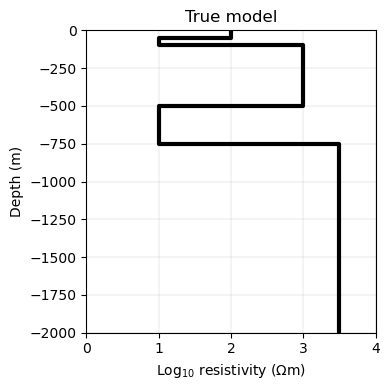

In [3]:
# layer electrical resitivity in log10 ohm.m 
true_model = np.array([2,1,3,1,3.5]) 
# depths in meters to the bottom of each layer (positive downwards), last layer infinite: len(true_depths)+1 = len(true_model)
true_depths = np.array([50,100,500,750])
# plot the model
max_depth=-2000
fig = mt.plot_model(true_model, true_depths, title='True model',max_depth = max_depth)

#### 0.2. Compute response of the model

In [4]:
#Define useful functions
from cofi_espresso._magnetotelluric_1D import get_frequencies, forward_1D_MT, z2rhophy, add_noise

Compute synthetic data, add noise, define the data / errors and plot

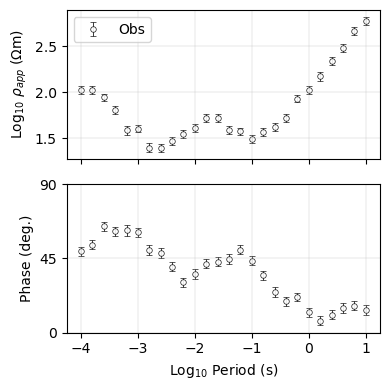

In [5]:
# define frequencies (in Hz) where responses are computed
fmin, fmax, f_per_decade = 1e-1, 1e4, 5
freqs = get_frequencies(fmin,fmax,f_per_decade)
# generate synthetic data 
# calculate impedance Z
Z = forward_1D_MT(true_model, true_depths, freqs, return_Z = True)
# add noise
Z, Zerr = add_noise(Z, percentage = 5, seed = 1234)
# transform Z to log10 apparent resistivity and phase (dobs)
dobs, derr = z2rhophy(freqs, Z, dZ=Zerr)
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [6]:
# the mesh used for the inversion contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model, mesh and data 

In [7]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)
mt.set_obs_data(dobs, derr, freqs)

## 1. Define the problem

The inversion consists in minimizing the following cost function:
$$\Phi=\Phi_d+{\lambda\Phi}_m$$

$\Phi_d$ is the data misfit term, defined as:
$$\Phi_d = ||W_d(d_{obs}-(F(m))||^2 = [d_{obs}-(F(m)]^T  W_d   [d_{obs}-(F(m)]$$

with $W_d$ being the inverse data covariance matrix, $d_{obs}$ is the observed data and $F(m)$ the responses of the model $m$.



$\Phi_m$ is the model norm term, defined as: 

$$\Phi_m=||L m||^2 = m^TL^TLm$$

In this inversion we minimize the model term using first derivatives, i.e. it minimizes the model roughness.  $\lambda$ is the regularization parameter, it defines the trade off between data misfit and model roughness. 

Following Brodie (2015) and Constable et al (1987) we define the regularization matrix $L$ as the first derivative operator $\partial$ normalized by the layers geometry vector $D$ (the resistivity gradient between adjacent layers is normalized by the distance between the center of layers). It is defined as:

$$L = D\circ\partial  $$

$L$ is a $N-1 \times N$ matrix, where $N$ is the number of model parameters $m$:

$$L=D\circ\partial= 
\frac{1}{(N -1)}
\begin{bmatrix}
\frac{\sqrt{s_2}}{d_{12}}\\
\frac{\sqrt{s_3}}{d_{23}}\\
\frac{\sqrt{s_4}}{d_{34}}\\
\cdots
\end{bmatrix}
\circ
\begin{bmatrix}
-1 & 1 & 0&0&&\cdots \\  
0& -1 & 1 &0&&\cdots \\ 
0& 0 & -1 &1&&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix} 
= \frac{1}{(N -1)} 
\begin{bmatrix}
\frac{-\sqrt{s_2}}{d_{12}} & \frac{\sqrt{s_2}}{d_{12}} & 0&0&&\cdots  \\  
0& \frac{-\sqrt{s_3}}{d_{23}} & \frac{\sqrt{s_3}}{d_{23}} &0&&\cdots \\ 
0& 0&\frac{-\sqrt{s_4}}{d_{34}} & \frac{\sqrt{s_4}}{d_{34}} &&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix}
$$

with $d_{ij}$ the distance between center of adjacent layers, and $s_k$ defined as $s_k=\frac{t_k}{\overline{t}}$ with $t$ beeing the layer thicknesses. See Brodie(2015) for details.

Following Key (2009) and Constable et al (1987), we can also define a penalty weights matrix $W_m$. The penalty weights matrix is a diagonal matrix applied to $L$. The weight $w_{ij}$ for the boundary beetween layer $i$ and $j$ defines the amount of smoothness constraint applied at that specific boundary. It is defined between 1 (smoothness applied) and 0 (no smoothness constraint) as each layer boundary. $W_m$ is a $N-1 \times N-1$ matrix defined as:

$$W_m = \begin{bmatrix}
w_{12} & 0 & 0 & 0&&\cdots \\  
0 & w_{23} & 0& 0&&\cdots \\ 
0 & 0 & w_{34}& 0&&\cdots \\ 
&&&\cdots&& \\
\end{bmatrix}$$

$W_m$ can be used to specify at which depths the smoothness constraint should be relaxed, allowing a sharp boundary to devellop. 

Finally, the regularization matrix $L$ takes the form:

$$L = W_m D\circ\partial$$


#### References:

Brodie, R. C. (2015). User manual for Geoscience Australia’s airborne electromagnetic inversion software. Online: https://github.com/GeoscienceAustralia/ga-aem.git.

Constable, S. C., Parker, R. L., & Constable, C. G. (1987). Occam’s inversion: A practical algorithm for generating smooth models from electromagnetic sounding data. Geophysics, 52(3), 289-300.

Key, K. (2009). 1D inversion of multicomponent, multifrequency marine CSEM data: Methodology and synthetic studies for resolving thin resistive layers. Geophysics, 74(2), F9-F20.


In [8]:
# define regularization (following Constable 1987, Brodie 2015)
def reg_mt(depths, lambda_reg = 1, depth_normalization = True, penalty_index = None):
    # nL is the number of layers, equal to the number of model parameters
    nL = len(depths) + 1
    #layers thicknesses
    th = [depths[i] - depths[i-1] for i in range(nL-1)] 
    th[0] = depths[0]
    #thickness bottom half space (following Brodie (2015))
    th = np.array(np.append(th, (th[-1])**2 / (th[-2]))) / 1000 #(in km)
    #distance between center of adjacent layers
    d_layers_centers = [((th[i]+th[i+1])/2) for i in range(len(th)-1)]
    #define depth factor
    if depth_normalization:
        #mean layers thickness
        th_mean = np.mean(th)
        # define s_k
        sk = [th[i]/th_mean for i in range(len(th))]
        #define depth_factor
        depth_norm = (1/(nL-1)) * np.array([np.sqrt(sk[i])/d_layers_centers[i] for i in range(nL-1)])
    else:
        depth_norm = [1/d_layers_centers[i] for i in range(nL-1)]
    depth_norm = np.array(depth_norm).reshape((-1,1))
    #define first derivative matrix 
    delta=((diags([-1, 1], [0,1], shape=(nL-1, nL)).toarray())) 
    #define penalty weights matrix
    Wm = np.identity(nL-1) 
    if penalty_index is None:
        return lambda_reg * Wm @ delta * (depth_norm)
    else:
        Wm[penalty_index,penalty_index] = 0.1
        return lambda_reg * Wm @ delta * (depth_norm)


In [9]:
# get problem information from  espresso mt
model_size = len(mt.starting_model)         # number of model parameters
data_size = mt.data_size           # number of data points
start_logres = mt.starting_model
starting_depths = mt._dpstart

In [10]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(start_logres)

In [11]:
L = reg_mt(starting_depths, lambda_reg = 10, depth_normalization = True, penalty_index = None)

In [12]:
def objective_func(logres, reg, depths = starting_depths):
    dpred = mt.forward(logres, depths=depths)
    reg_smooth = logres.T @ reg.T @ reg @ logres
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    return  data_misfit + reg_smooth

In [13]:
mt_problem.set_objective(objective_func, args=[L,starting_depths])

In [14]:
#mt_problem.summary()

## 2. Define the inversion options

In [15]:
#mt_problem.suggest_tools();

In [16]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [17]:
#my_options.suggest_solver_params()

## 3.1 Start an inversion

In [18]:
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 1.615898017936349
jac: [-7.98440430e-02 -6.93621165e-02 -1.30907064e-02 -2.87761372e-02
 -1.09018129e-02 -3.23604923e-02 -5.10865131e-02 -3.79560830e-02
 -3.06221717e-03  2.53198353e-02  1.53709491e-02  1.41291424e-03
 -1.18489441e-02 -2.41811461e-02  2.20639952e-02  3.84489554e-02
 -2.75988345e-02 -8.41120068e-02  1.44123825e-02 -7.38296095e-03
 -5.52094596e-02 -3.29188678e-02  8.17586004e-03 -6.92712558e-03
 -6.24464706e-02 -1.12007226e-01 -1.85385353e-01 -2.81882652e-01
 -2.73364066e-01 -1.93579243e-01 -1.25620115e-01 -9.31122296e-02
 -7.53980438e-02 -4.41568118e-02 -1.89330996e-02 -1.29978251e-02
 -1.46015645e-02 -1.52903247e-02 -1.45086610e-02 -1.33608236e-02
 -1.23642874e-02 -1.16021859e-02 -1.10417898e-02 -1.06296750e-02
 -1.03310472e-02 -1.01127107e-02 -9.95521449e-03 -9.84337062e-03
 -9.77320453e-03 -9.73938713e-03 -9.74125231e-03 -9.77737897e-03
 -9.84781152e-03 -9.94722089e-03 -1.00673470e-02 -1.01858300e

## 3.2 Plot inversion results

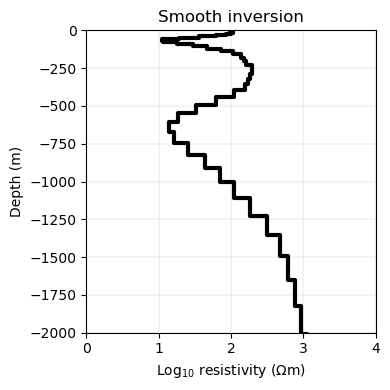

In [19]:
#fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)
#fig = mt.plot_model(mt.good_model, title='True model')
fig1 = mt.plot_model(inv_result.model, depths = mt._dpstart, max_depth = max_depth, title='Smooth inversion');            # inverted model

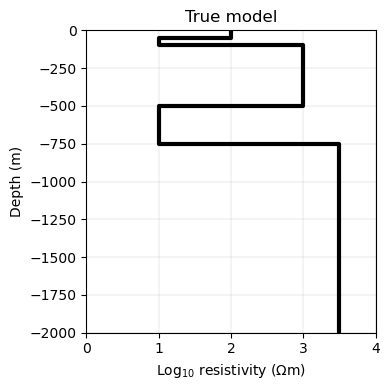

In [20]:
fig2 = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model

nRMSE = 1.058


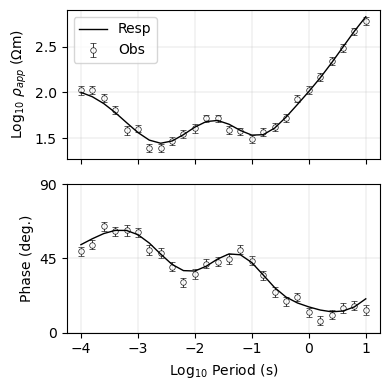

In [21]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm_inv = mt.inverse_covariance_matrix))
print('nRMSE = %.3f'%nRMSE)

## 4.1 Start a constrained inversion

Now, let's try to constrain the inversion, relaxing the smoothness constraint at the top of the resistive layer at -750 meters depth. This information could be coming from another geophysical model, or a drillhole.

In [22]:
# list the interface depths of our current starting model
# [print('z = %8.1f m at index i = %3d'%(mt._dpstart[i],i)) for i in range(len(mt._dpstart))];

If for example we expect changes of resistivity at depths z = 1000 m, we can modify the mesh to match our prior information

In [23]:
idx = [28]
starting_depths[idx] = 750
#idx = [11,28]
#starting_depths[idx] = 100,750
mt.set_start_mesh(starting_depths)
[print('z = %8.1f m at index i = %3d'%(mt._dpstart[idx[i]],idx[i])) for i in range(len(idx))];

z =    750.0 m at index i =  28


In [24]:
L_constrained = reg_mt(starting_depths, lambda_reg = 10, depth_normalization = True, penalty_index = idx)

In [25]:
mt_problem_constrained = cofi.BaseProblem()
mt_problem_constrained.set_initial_model(start_logres)
mt_problem_constrained.set_objective(objective_func, args=[L_constrained,starting_depths])

In [26]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
inv_constrained = cofi.Inversion(mt_problem_constrained, my_options)
inv_result_constrained = inv_constrained.run()
inv_result_constrained.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 1.551726161962935
jac: [-1.81527905e-02  2.16370034e-02 -3.34392516e-03  2.84263281e-02
 -2.01600959e-02 -2.06668239e-02 -5.64785999e-03 -8.13178418e-03
 -1.39804169e-02  1.31815226e-02  4.27160532e-02  1.02566400e-02
 -2.95244719e-02 -1.22086342e-02 -3.01459304e-02  6.99289519e-03
  6.54367675e-03 -2.30864662e-02 -4.92494937e-03  3.14201556e-02
 -1.66537896e-02 -2.37303068e-02  1.22677425e-02  3.03527427e-02
  8.29558649e-04 -1.37404755e-02  1.24040334e-02  3.78991063e-02
  3.66016993e-02 -2.11533015e-03  8.20543638e-04  6.19637678e-04
  3.90096846e-03  1.44968483e-03  3.55937504e-03  7.55306933e-04
 -3.31188412e-03 -3.54152265e-03 -1.88276063e-03 -6.18505251e-04
 -1.35491619e-04 -9.69668796e-05 -2.35367283e-04 -4.30588900e-04
 -6.34425849e-04 -8.30757690e-04 -1.01203491e-03 -1.17761357e-03
 -1.32889256e-03 -1.46411772e-03 -1.58189018e-03 -1.67814652e-03
 -1.73865368e-03 -1.74624760e-03 -1.66962001e-03 -1.46018754e

## 4.2 Plot inversion results

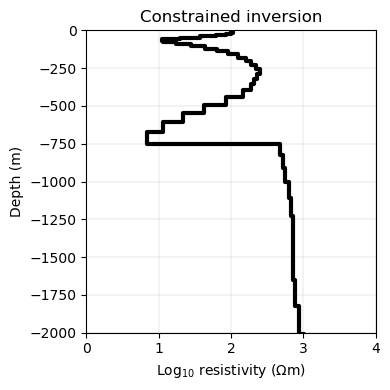

In [27]:
fig1 = mt.plot_model(inv_result_constrained.model, depths = mt._dpstart, max_depth = max_depth, title='Constrained inversion');  

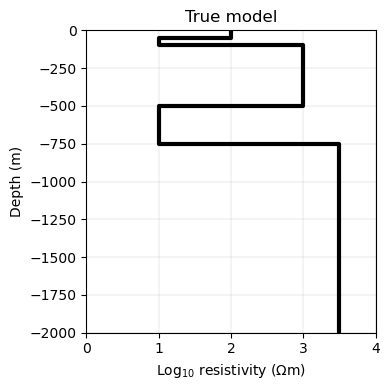

In [28]:
fig = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model"

nRMSE = 1.037


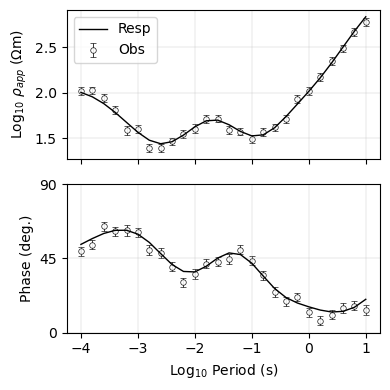

In [29]:
fig = mt.plot_data(mt.data, mt.forward(inv_result_constrained.model,depths=starting_depths), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result_constrained.model,depths=starting_depths), Cm_inv = mt.inverse_covariance_matrix))
print('nRMSE = %.3f'%nRMSE)

#### Warning:

Due to the high non-uniqueness of the MT problem, setting-up a-priori constraints on depths at which a sharp boundary is expected can be misleading. For example, in the example above, if an innacurate a-priori constraint is used, the inversion might still be able to converge to an acceptable solution while presenting a sharp boundary at a wrong depth.